# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [33]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [34]:
import random

random.seed(10)

#### Import experiment data 

In [35]:
from DATA import NARMA10

data = NARMA10(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [36]:
N_UNITS = 150

In [37]:
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

In [38]:
Y_TS.shape

torch.Size([2000])

In [39]:
esn = EchoStateNetwork(simple_reservoir) 

In [40]:
esn.train(X_TR, Y_TR, 0, 100, True)

Reservoir warmed up with the first 100 time steps


array([0.2734375, 0.25     , 0.2578125, ..., 0.3046875, 0.25     ,
       0.2265625], dtype=float32)

1.9723705392377104

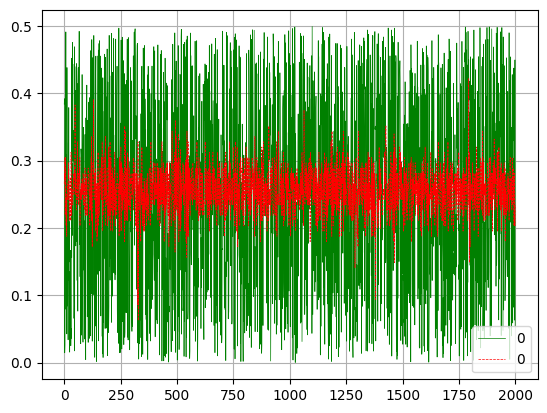

In [41]:
esn.evaluate(X_TS,Y_TS,plot=True)

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [42]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [43]:
ip_reservoir.pre_train(X_TR, eta=0.000005, epochs=10,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 2725.845458984375.
- Epoch: 2) | KL Divergence value: 2707.87939453125.
- Epoch: 3) | KL Divergence value: 2689.991943359375.
- Epoch: 4) | KL Divergence value: 2672.205078125.
- Epoch: 5) | KL Divergence value: 2654.543212890625.
- Epoch: 6) | KL Divergence value: 2637.025390625.
- Epoch: 7) | KL Divergence value: 2619.669921875.
- Epoch: 8) | KL Divergence value: 2602.489501953125.
- Epoch: 9) | KL Divergence value: 2585.50146484375.
- Epoch: 10) | KL Divergence value: 2568.7080078125.


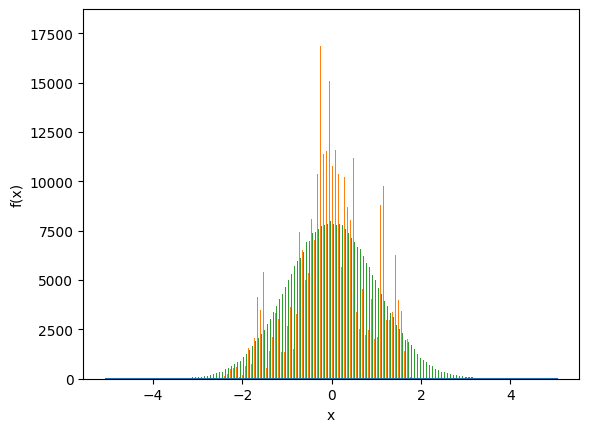

In [44]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [45]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.6614378094673157)  ACTUAL_STD == (0.02919429913163185)][ TARGET_MEAN == (0.011199906468391418) TARGET_STD == (0.9808833599090576)]
Unit - (2): [ ACTUAL_MEAN == (1.0804208517074585)  ACTUAL_STD == (0.06892319023609161)][ TARGET_MEAN == (-0.006400236394256353) TARGET_STD == (1.0153489112854004)]
Overall network: [ACTUAL_MEAN == (0.015114602632820606)  ACTUAL_STD == (0.8258460164070129)]


## BIMODAL MIXTURE OF GAUSSIAN

In [46]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [47]:
bimodal_reservoir.pre_train(X_TR, eta= 0.0000015, epochs=15,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3383.94580078125.
- Epoch: 2) | KL Divergence value: 3221.26806640625.
- Epoch: 3) | KL Divergence value: 3067.328857421875.
- Epoch: 4) | KL Divergence value: 2922.642822265625.
- Epoch: 5) | KL Divergence value: 2787.55078125.
- Epoch: 6) | KL Divergence value: 2662.223876953125.
- Epoch: 7) | KL Divergence value: 2546.68310546875.
- Epoch: 8) | KL Divergence value: 2440.81591796875.
- Epoch: 9) | KL Divergence value: 2344.39306640625.
- Epoch: 10) | KL Divergence value: 2257.10595703125.
- Epoch: 11) | KL Divergence value: 2178.56396484375.
- Epoch: 12) | KL Divergence value: 2108.34228515625.
- Epoch: 13) | KL Divergence value: 2045.9727783203125.
- Epoch: 14) | KL Divergence value: 1990.964111328125.
- Epoch: 15) | KL Divergence value: 1942.8287353515625.


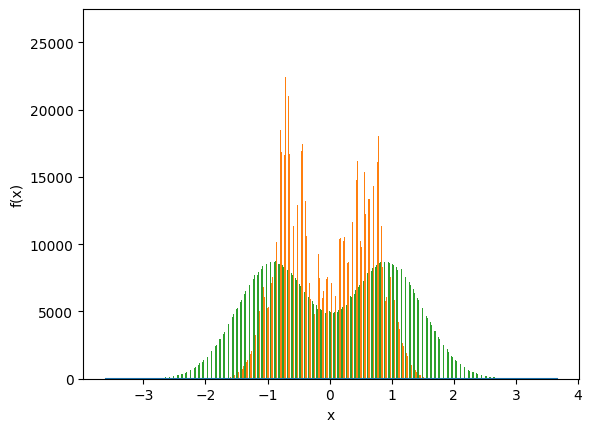

In [48]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [49]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.8023107647895813)  ACTUAL_STD == (0.03277662768959999)][ TARGET_MEAN == (-0.9210387468338013) TARGET_STD == (0.58458411693573)]
Unit - (2): [ ACTUAL_MEAN == (0.914576530456543)  ACTUAL_STD == (0.0811578631401062)][ TARGET_MEAN == (0.9201743602752686) TARGET_STD == (0.576724648475647)]
Overall network: [ACTUAL_MEAN == (-0.035969872027635574)  ACTUAL_STD == (0.6702233552932739)]


## EVAUALTUION IN ESN

In [50]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.reservoir.warm_up(X_TR[0:100])
ip_esn.reservoir.warm_up(X_TR[0:100])
bimodal_esn.reservoir.warm_up(X_TR[0:100])

simple_esn.train(X_TR[100:None], Y_TR[100:None], 0)
ip_esn.train(X_TR[100:None], Y_TR[100:None], 0)
bimodal_esn.train(X_TR[100:None], Y_TR[100:None], 0)


Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps


array([0.2734375 , 0.19726562, 0.2265625 , ..., 0.27929688, 0.26367188,
       0.30273438], dtype=float32)

### COMPARISON ON TEST DATA

In [51]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.023767513068324305


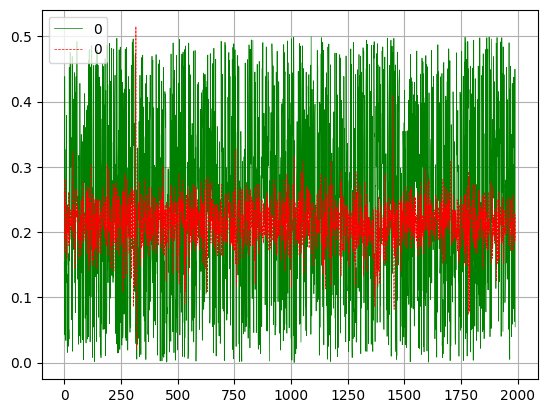

In [52]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.023374124643876008


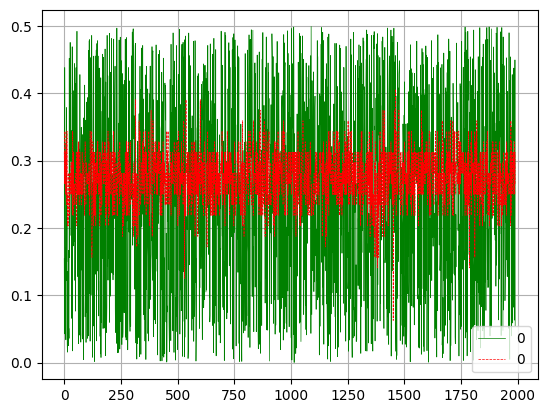

In [53]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.021838539132373182


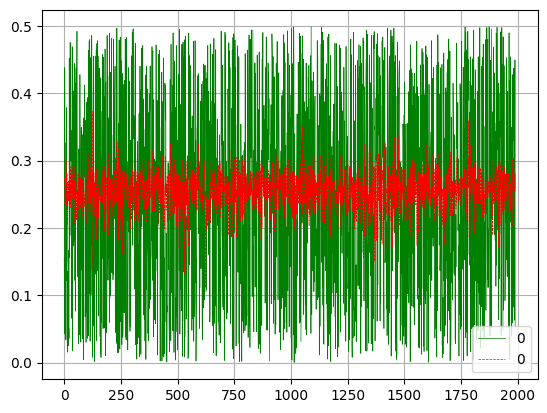

In [54]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

## LYAPUNOV EXPONENTS

In [55]:
simple_esn.reservoir.LCE(X_TS)

-1.9564918

In [56]:
ip_esn.reservoir.LCE(X_TS)

-1.5464036

In [57]:
bimodal_esn.reservoir.LCE(X_TS)

-1.7151175

## MEMORY CAPACITY

In [58]:
def mean_mc(esn: EchoStateNetwork, rep):
    mc = 0
    for _ in range(rep):
        mc += esn.MemoryCapacity()

    return mc/rep

In [59]:
mean_mc(simple_esn, 5)

tensor(6.7611)

In [60]:
mean_mc(ip_esn, 5)

tensor(10.9339)

In [61]:
mean_mc(bimodal_esn, 5)

tensor(11.0386)

## DEVIATION FROM LINEARITY

In [62]:
simple_esn.reservoir.de_fi()

0.22939283626893212


In [63]:
ip_esn.reservoir.de_fi()

0.23168739354314638


In [64]:
bimodal_esn.reservoir.de_fi()

0.23166291535338343
